# EDA - Walmart - preprocessing
> # index
### 1. 데이터 불러오기 및 함수 호출
### 2. 사전 데이터정제 및 garbage값 제거 (근거 간략요약)
    0) 3년기간동안 units가 모두 = 0 인 값 제거(존재하지않는 아이템값은 0이라고 가정한다)
    2) 데이터열 자료형 최적화
    3) 날씨코드구분
    4) 전체데이터 조합
    5) 날짜분할(년,월,일), 온도차, 컬럼생성
### 3. 데이터 column간 유사성/상관수준 비교
### 4. 병합 및 기타 삽질... ㅜㅜㅜㅜㅜㅜㅜㅜ
### 5. 특성상세분석
### 6. 회귀분석(... 어떻게하는건데 ㅜㅜ)
### 7. likelihood함수의 변수삽입
    
### 부록 : 데이터 정제 근거자료

---
# 1. 데이터 불러오기 및 함수호출=========================



In [148]:
#주피터노트북 그래프설정

%matplotlib inline
#주피터노트북에서 라인 아래에 보여지도록 설정

%config InlineBackend.figure_formats = {'png','retina'} 
#png 이미지 압축기술설정, retina 그래프 해상도 2배 높히기

#그래프 한글폰트 설정
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc

#그래프 한글폰트 설정
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgunbd.ttf").get_name()
rc('font', family=font_name)
#음수처리
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
import os
import datetime as dt
import numpy as np
import pandas as pd
import pandas_profiling as pdp

C:\Users\creal\Anaconda3\lib\site-packages\matplotlib\__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
#전체기후날씨데이터(weather.csv) 불러오기--------------------------
weather = pd.read_csv('weather.csv')
# weather["date"]=weather["date"].astype("datetime64[ns]") #-----열 선택하여 형변환
#지점-기후관측소 대조표(key.csv) 불러오기
map_key = pd.read_csv('key.csv')

#일일-지점-상품-판매량 정보(train.csv) 불러오기
store_data = pd.read_csv('train.csv')

#판매량 예측을 위한 지점정보(test.csv) 불러오기
test = pd.read_csv('test.csv')

In [4]:
# ★ 함수선언 ------------------------------------------------------
#-------날씨요소기준// 날짜-스테이션 데이터 도출함수
def weather_pivot(column_name):

    station_itm = pd.DataFrame(weather,columns=["station_nbr","date",column_name])

        # 스테이션별 피봇팅(테이블)
    station_value = station_itm.pivot("date","station_nbr",column_name)
    station_table = station_value.apply(pd.to_numeric, errors = 'coerce')

    return station_table
    

#--------날씨요소기준// 날짜별 스테이션(숫자형)날씨요소 평균 도출함수---------
def weather_mean(column_name):
    station_itm = pd.DataFrame(weather,columns=["date","station_nbr",column_name])
        # 데이터타입 숫자화(이거 안되면 에러나니까 꼭 타입정제부터 하자)
    temp_df = station_itm.replace(["M",None],np.NaN) #--특정문자 NaN으로 변환
    temp_df = temp_df.replace(["T","  T"],0.005)
    station_itm = temp_df.apply(pd.to_numeric, errors = 'ignore')
        # 평균구해넣기
    avg_df = station_itm.pivot_table(column_name,["date"], aggfunc=np.mean)
    avg_df = avg_df.apply(pd.to_numeric, errors = 'ignore')

    return avg_df


#--------날씨요소기준// 스테이션-전체날짜 날씨요소평균 도출함수---------
def station_mean(column_name):
    station_itm = pd.DataFrame(weather,columns=["station_nbr","date",column_name])
        # 데이터타입 숫자화(이거 안되면 에러나니까 꼭 타입정제부터 하자)
    temp_df = station_itm.replace(["M",None],np.NaN) #--특정문자 NaN으로 변환
    temp_df = temp_df.replace(["T","  T"],0.005)
    station_itm = temp_df.apply(pd.to_numeric, errors = 'ignore')
        # 평균구해넣기
    station_avg = station_itm.pivot_table(column_name,["station_nbr"], aggfunc=np.mean)
    station_avg = station_avg.apply(pd.to_numeric, errors = 'ignore')
    
    return station_avg

#=============================================================================

#------★★완전체 형변환 함수(M,T,__T,None)==> 있는열도 변환 가능
def type_change_numeric(df, ls = []): 
    #ls에 있는 column name은 numeric형으로 바꾸지 않는다.
    cols = df.columns
    for i in cols:
        if i in ls:
            continue 
        df = df.replace(["M",None],np.NaN)
        df = df.replace(["T","  T"],0.005)
        df[i] = pd.to_numeric(df[i], errors='coerce')
        
    return df



In [6]:
#weather_p에 사전정제자료 삽입(codesum은 추가정제필요)
weather_p = type_change_numeric(weather,["station_nbr","codesum","date"])
weather_p["date"] = pd.to_datetime(weather_p["date"])
weather_p["tdelta"] = weather_p["tmax"]-weather_p["tmin"]
weather_p["RA"] = weather_p['codesum'].str.contains("RA")== True
weather_p["BR"] = weather_p['codesum'].str.contains("BR")== True
weather_p["HZ"] = weather_p['codesum'].str.contains("HZ")== True
weather_p["TS"] = weather_p['codesum'].str.contains("TS")== True
weather_p["FG"] = weather_p['codesum'].str.contains("FG")== True
weather_p["SN"] = weather_p['codesum'].str.contains("SN")== True

In [7]:
weather_p.dtypes

station_nbr             int64
date           datetime64[ns]
tmax                  float64
tmin                  float64
tavg                  float64
depart                float64
dewpoint              float64
wetbulb               float64
heat                  float64
cool                  float64
sunrise               float64
sunset                float64
codesum                object
snowfall              float64
preciptotal           float64
stnpressure           float64
sealevel              float64
resultspeed           float64
resultdir             float64
avgspeed              float64
tdelta                float64
RA                       bool
BR                       bool
HZ                       bool
TS                       bool
FG                       bool
SN                       bool
dtype: object

---
# 2. 사전 데이터정제 및 Garbage값 제거===================

In [8]:
# 0) units = 0 인값 제거한 데이터프레임 만들기 (주의! units=0인값이 전혀 나오지 않게됩니다.)
 #  └-- 장점으로는 계산이 빠르다 + 없는값을 제외하고 볼 수 있어서 그래프 그릴때 편하다. 
store_df = store_data[store_data["units"]!=0]

In [212]:
#   └--units = 0인값을 다시 복구하고 싶을시 사용하시오 (주의! 뭘하든 오래걸리게됩니다.)
store_df = store_data 

In [11]:
# 1) 데이터 형변환(날짜 및 숫자)
import time

store_df["date"] = pd.to_datetime(store_df["date"])
weather_p["date"] = pd.to_datetime(weather_p["date"])

C:\Users\creal\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [12]:
# 4) 전체데이터 조합 merge
#- 1. store_data에 스테이션 넘버 부여
result_df = store_df.merge(map_key, left_on="store_nbr", right_on="store_nbr" )
cols = ['date', 'store_nbr', 'station_nbr', 'item_nbr', 'units']
new_df = result_df[cols] #열 위치변경된 것들
#- 2. 종합세팅
all_set = new_df.merge(weather_p, left_on=["date","station_nbr"], right_on=["date","station_nbr"] )

In [13]:
# 데이터타입 날짜화 및 int화(이거 안되면 에러나니까 꼭 타입정제부터 하자)
all_set["date"]=all_set["date"].astype("datetime64[ns]") #-----열 선택하여 형변환
temp_df = type_change_numeric(all_set,["date","store_nbr","item_nbr","units","station_nbr","codesum"])

In [14]:
master = all_set.sort_values(["date","store_nbr","item_nbr"])

In [68]:
#날짜 분해 및 데이터정제

master['year'] = master['date'].dt.year
master['month'] = master['date'].dt.month
master['day'] = master['date'].dt.day
master['DOW']= master['date'].dt.dayofweek
master['SS']= (master['month']//3)%4 
#ss는 SeaSon의 약자로 0겨울 1봄 2여름 3가을 이다.

In [78]:
master[master["month"]==12]

,date,store_nbr,station_nbr,item_nbr,units,tmax,tmin,tavg,depart,dewpoint,...,BR,HZ,TS,FG,SN,year,month,day,DOW,SS
961,2012-12-01,1,1,9,53,29.0,25.0,27.0,NaN,18.0,...,True,True,False,False,True,2012,12,1,5,0
962,2012-12-01,1,1,28,8,29.0,25.0,27.0,NaN,18.0,...,True,True,False,False,True,2012,12,1,5,0
963,2012-12-01,1,1,40,1,29.0,25.0,27.0,NaN,18.0,...,True,True,False,False,True,2012,12,1,5,0
964,2012-12-01,1,1,51,3,29.0,25.0,27.0,NaN,18.0,...,True,True,False,False,True,2012,12,1,5,0
6486,2012-12-01,2,14,5,118,77.0,49.0,63.0,20.0,52.0,...,True,False,False,False,False,2012,12,1,5,0
6487,2012-12-01,2,14,44,258,77.0,49.0,63.0,20.0,52.0,...,True,False,False,False,False,2012,12,1,5,0
14798,2012-12-01,3,7,5,157,76.0,48.0,62.0,NaN,50.0,...,True,False,False,False,False,2012,12,1,5,0
14799,2012-12-01,3,7,45,143,76.0,48.0,62.0,NaN,50.0,...,True,False,False,False,False,2012,12,1,5,0
14800,2012-12-01,3,7,93,4,76.0,48.0,62.0,NaN,50.0,...,True,False,False,False,False,2012,12,1,5,0
21320,2012-12-01,4,9,9,73,47.0,35.0,41.0,NaN,37.0,...,True,True,False,False,False,2012,12,1,5,0


---
# 3. 데이터 column간 유사성, 상관성 분석

In [17]:
#----------이제 특정 함수를 써보자!

#1. 이슬점온도
station_dewpoint = weather_pivot("dewpoint")
station_dewpoint_avg = weather_mean("dewpoint")

#2. 하루평균온도
station_temp = weather_pivot("tavg")
station_temp_avg = weather_mean("tavg")

#3. 하루평균 바람세기
station_speed = weather_pivot("avgspeed")
station_speed_avg = weather_mean("avgspeed")
station_speed_eachavg = station_mean("avgspeed")

#4. 기압도
station_pressure = weather_pivot("stnpressure")
station_pressure_avg = weather_mean("stnpressure")
station_pressure_eachavg = station_mean("stnpressure") #개별 스테이션별 평균 기압

#5. 이상기후온도
station_depart = weather_pivot("depart")
station_depart_avg = weather_mean("depart")

#6. 적셜량
station_snow = weather_pivot("snowfall")
station_snow_avg = weather_mean("snowfall")
station_snow_eachavg = station_mean("snowfall") #개별 스테이션별 평균 적설량

#7. 강우량
station_rain = weather_pivot("preciptotal")
station_rain_avg = weather_mean("preciptotal")
station_rain_eachavg = station_mean("preciptotal") #개별 스테이션별 평균 적설량

#8. 바람방향
station_dir = weather_pivot("resultdir")
station_dir_avg = weather_mean("resultdir")
station_dir_eachavg = station_mean("resultdir")
                           

In [18]:
# 스토어별 아이템 총 판매량
store_item = new_df.pivot_table("units","store_nbr","item_nbr", aggfunc=np.sum)
# avg_df = station_itm.pivot_table(column_name,["date"], aggfunc=np.mean)
store_item

item_nbr,1,2,3,4,5,6,7,8,9,10,...,102,103,104,105,106,107,108,109,110,111
store_nbr,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27396.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,55104.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,1083.0,NaN,NaN,56663.0,NaN,NaN,NaN,NaN,NaN,...,31.0,NaN,NaN,NaN,NaN,NaN,NaN,1394.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117123.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50431.0,NaN,...,NaN,NaN,NaN,NaN,NaN,534.0,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,62230.0,NaN,721.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,32647.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,45024.0,NaN,NaN,NaN,NaN,745.0,...,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
#스토어가 판매하는 아이템수, 아이템이 팔리는 스토어 수
store_item["sales_items"] = store_item[store_item!=0].T.count()
store_item.loc[99] = store_item[store_item!=0].count()
store_item

item_nbr,1,2,3,4,5,6,7,8,9,10,...,103,104,105,106,107,108,109,110,111,sales_items
store_nbr,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27396.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
2,NaN,NaN,NaN,NaN,55104.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
3,NaN,1083.0,NaN,NaN,56663.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1394.0,NaN,NaN,6
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117123.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,6
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50431.0,NaN,...,NaN,NaN,NaN,NaN,534.0,NaN,NaN,NaN,NaN,4
7,NaN,NaN,NaN,NaN,62230.0,NaN,721.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
8,NaN,NaN,NaN,NaN,32647.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
9,NaN,NaN,NaN,NaN,45024.0,NaN,NaN,NaN,NaN,745.0,...,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,6


---
***
# 5. 상세분석------------------------------------------

---
# 아이템별 판매량 분석

### - 아이템과 스토어의 판매 관계

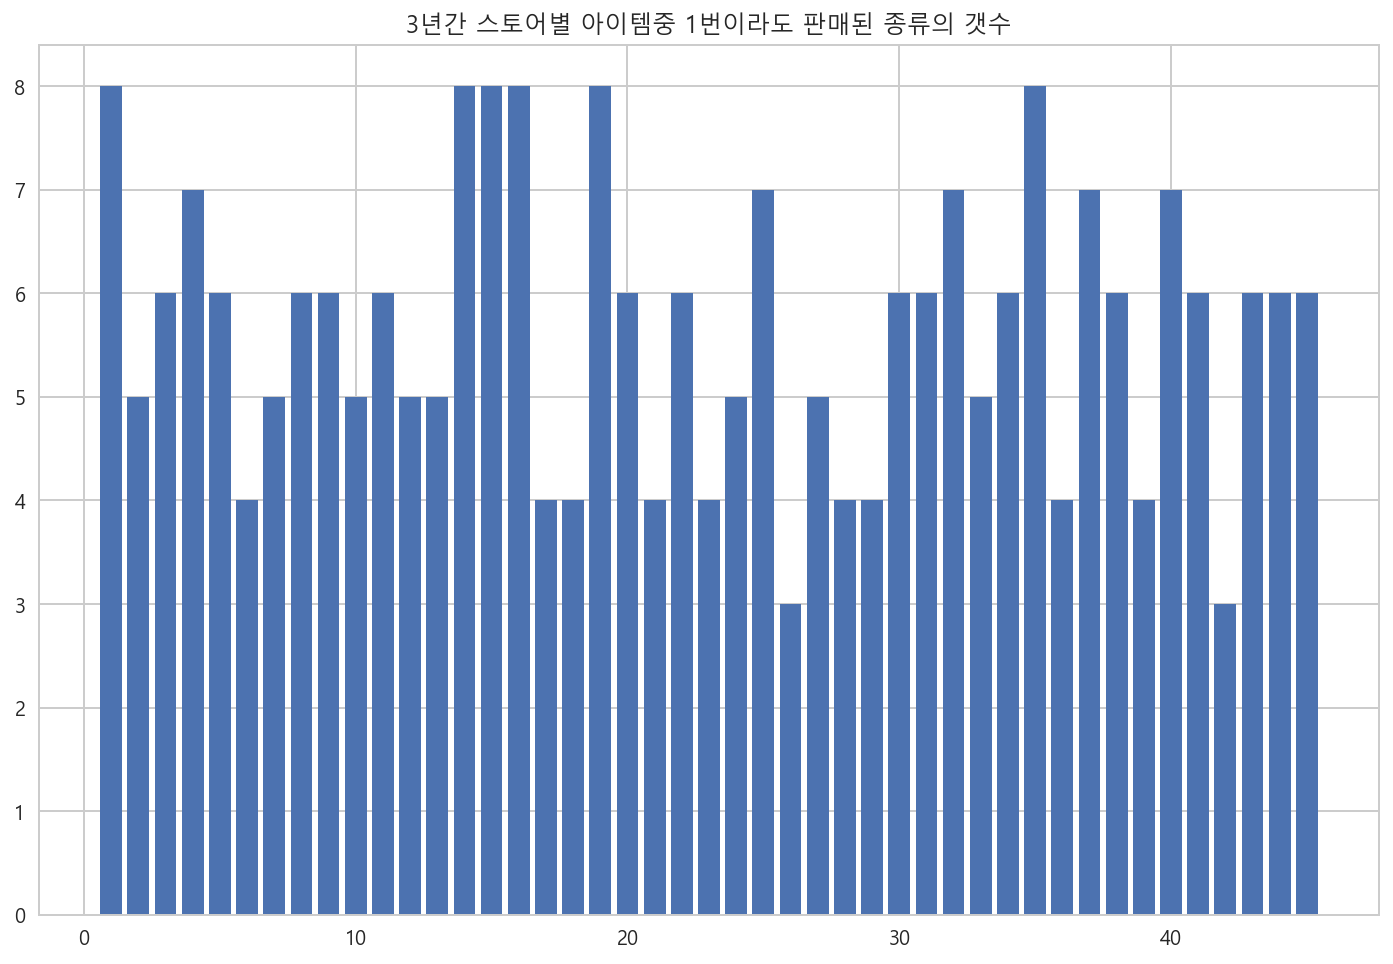

In [62]:
plt.figure(figsize=(12,8))
X = range(1,len(store_item["sales_items"]))
plt.title("3년간 스토어별 아이템중 1번이라도 판매된 종류의 갯수")
plt.bar(X,store_item["sales_items"][:45],label="sales_item")

plt.show()

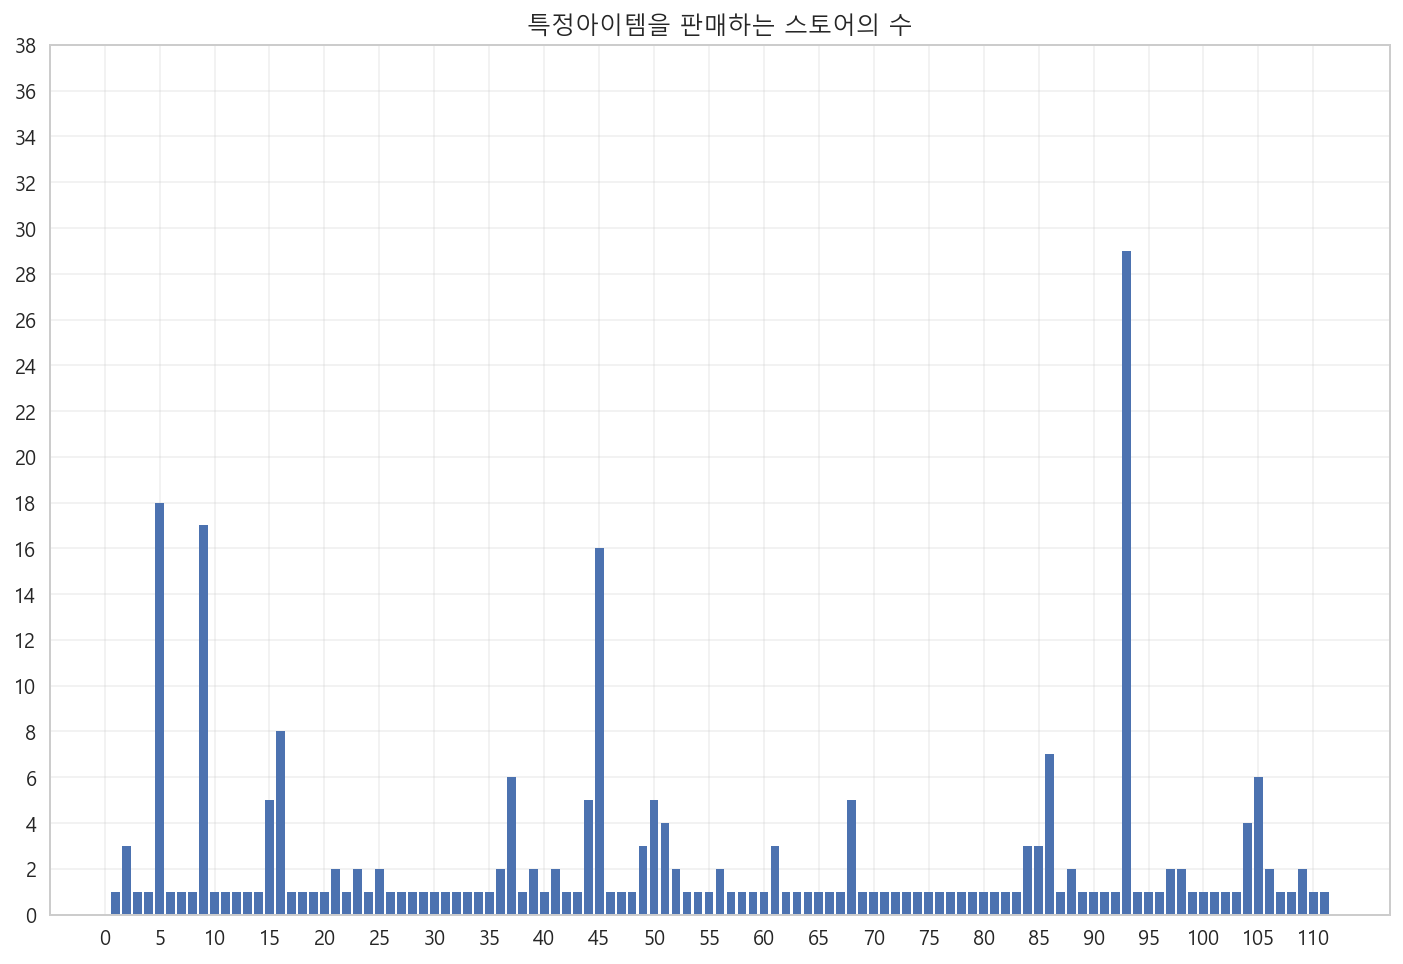

In [64]:
plt.figure(figsize=(12,8))
X = range(1,len(store_item.T[99]))
plt.title("특정아이템을 판매하는 스토어의 수")
plt.bar(X,store_item.T[99][:111],label="sales_item")

plt.xticks(range(0,115,5))
plt.yticks(range(0,40,2))
plt.grid(alpha = 0.25)

plt.show()

### - 전체기준 X아이템넘버/Y판매갯수 추이 

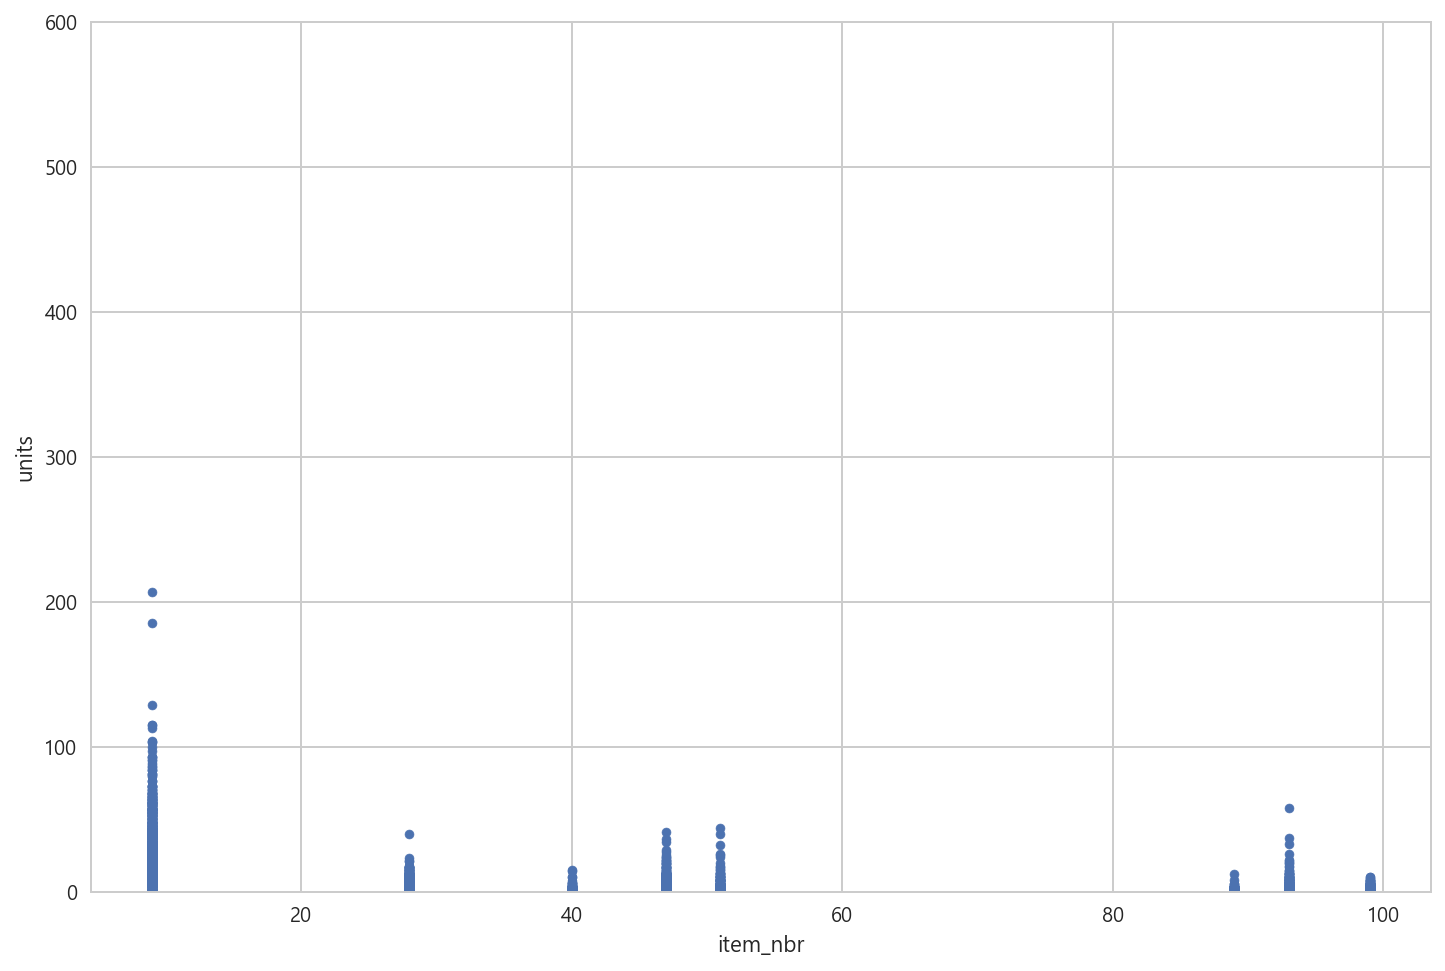

In [22]:
#각 아이템별 판매정도 추이
master[master["store_nbr"]==1].plot.scatter(x="item_nbr",y="units",figsize=(12,8),ylim=(0,600),style="hex")

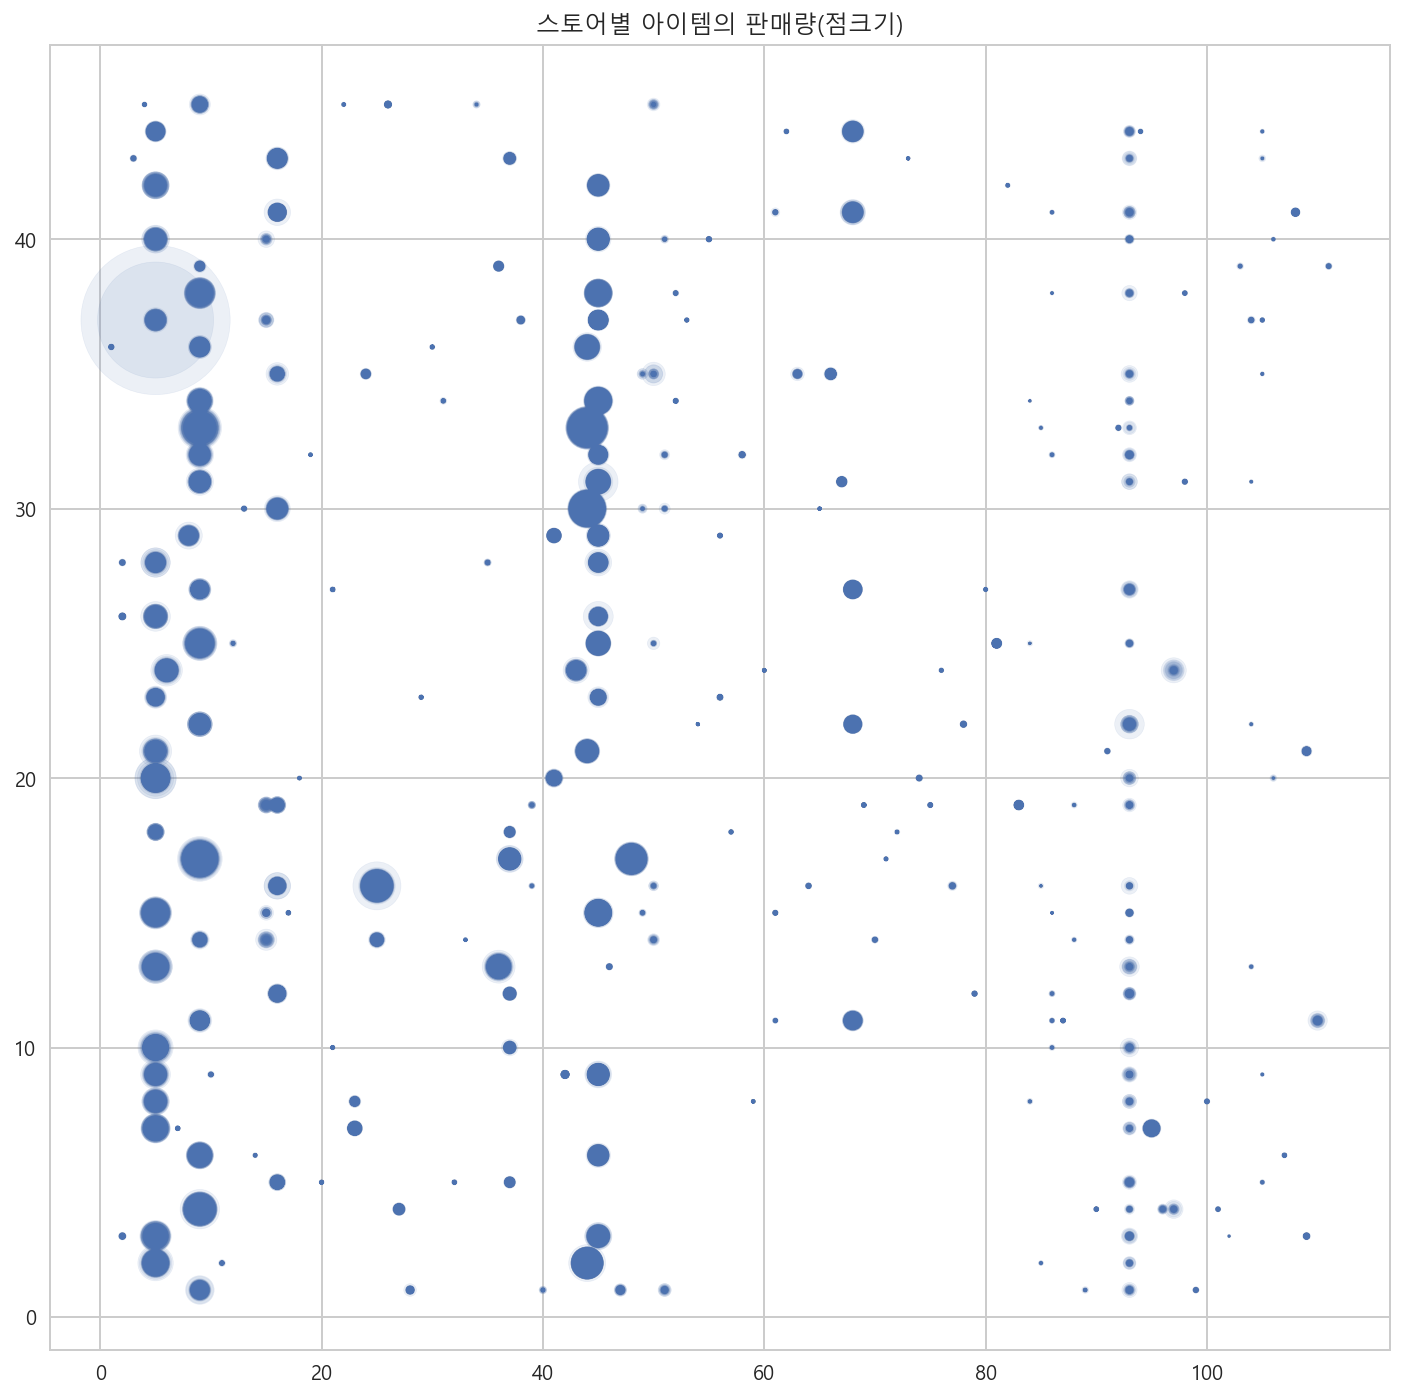

In [27]:
# 스토어, 아이템, 판매량(크기), 요일
plt.figure(figsize=(12,12))
x = master["item_nbr"]
y1 = master["store_nbr"]
# y2 = master["DOW"]
y3 = master["units"]
plt.grid(10)
plt.title("스토어별 아이템의 판매량(점크기)")
plt.scatter(x, y1, s=y3, alpha=0.1)
plt.show()

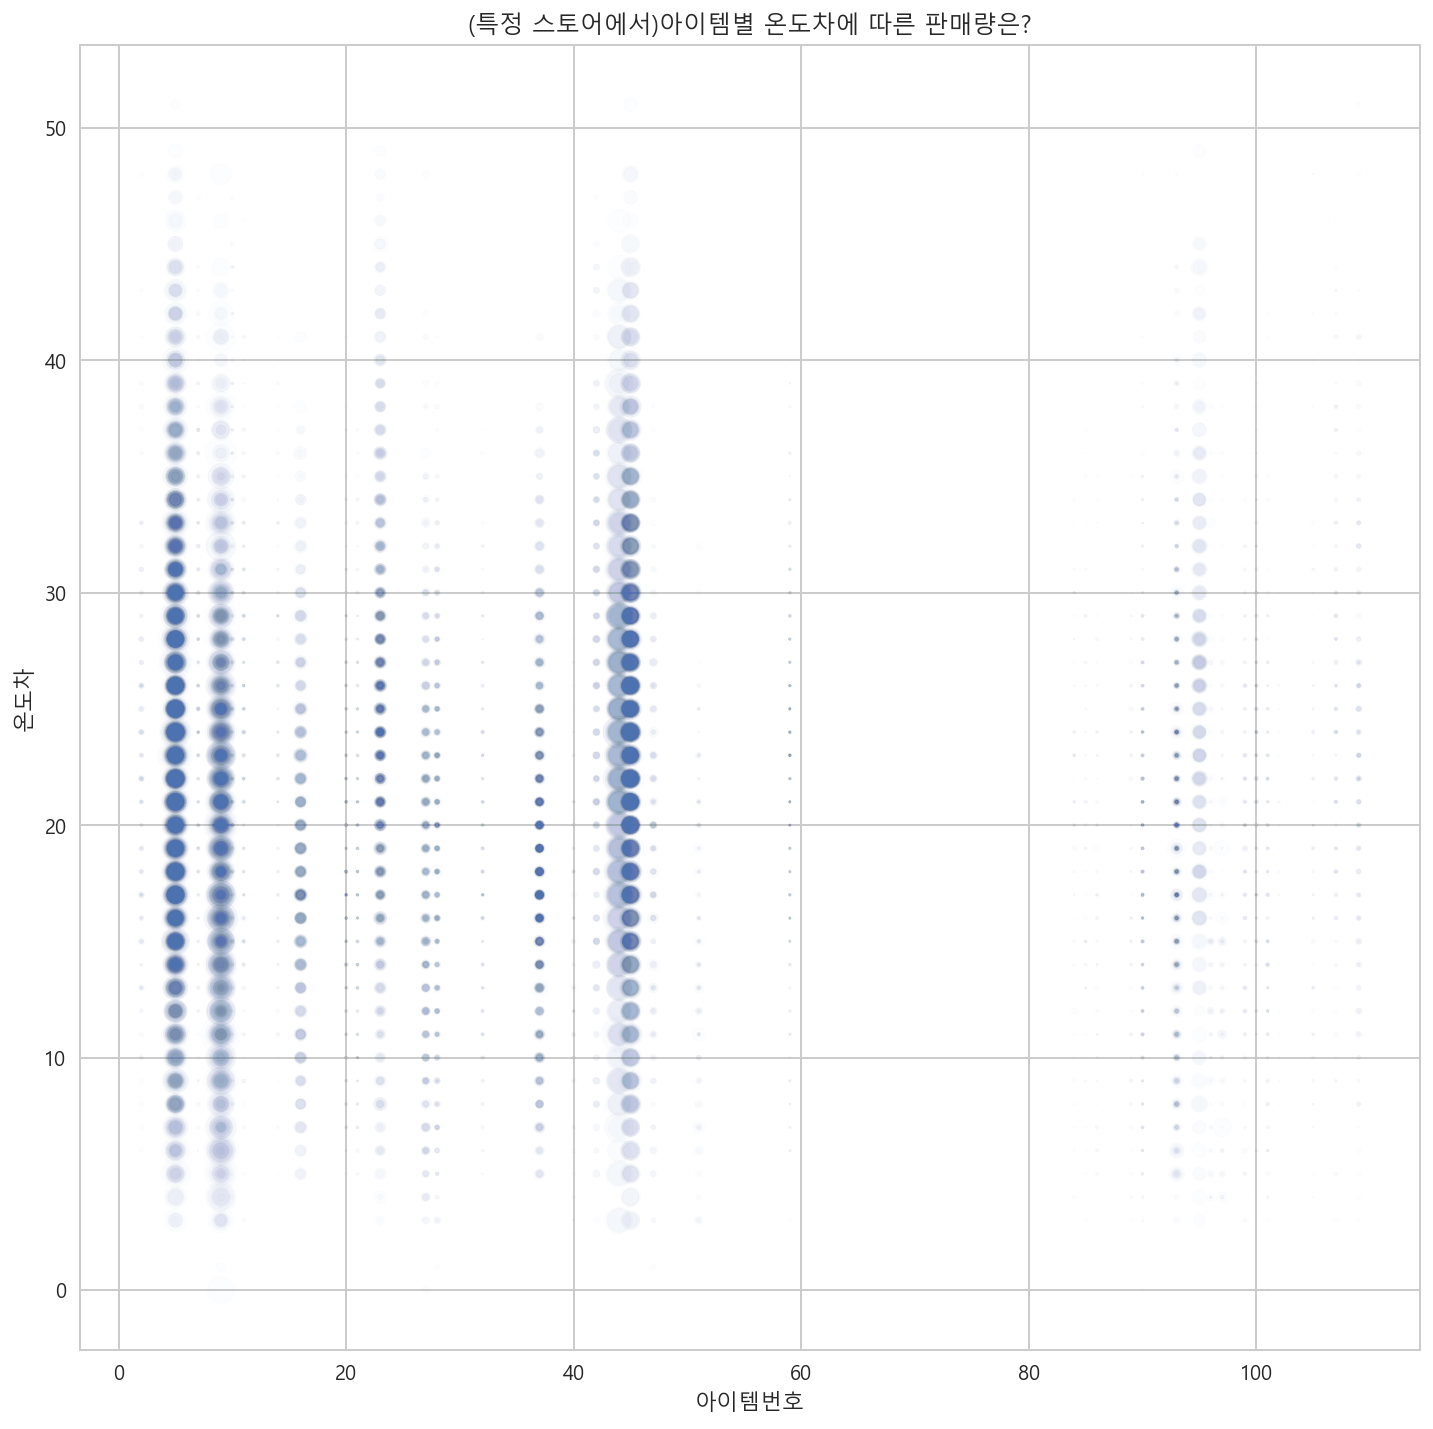

In [26]:
# 1차조건부 스토어, 아이템, 갯수, 요일, 온도차, 비의 여부 (빈도수가 높을수록 진하게 표시됨)
#  └-- scatter 등

#조건설정
cond = master[(master["store_nbr"]<=10)]

plt.figure(figsize=(12,12))
x = cond["item_nbr"]
y1 = cond["tdelta"]
# y2 = cond["DOW"]
y3 = cond["units"]
plt.xlabel("아이템번호")
plt.ylabel("온도차")
plt.title("(특정 스토어에서)아이템별 온도차에 따른 판매량은?")
plt.grid(10)
plt.scatter(x, y1, s=y3, alpha=0.01)
# plt.plot(x, y3 ,alpha=0.5)
# plt.bar(x,,alpha=0.1)
# plt.legend()
plt.show()

### - 날씨코드에 따른 아이템 판매량

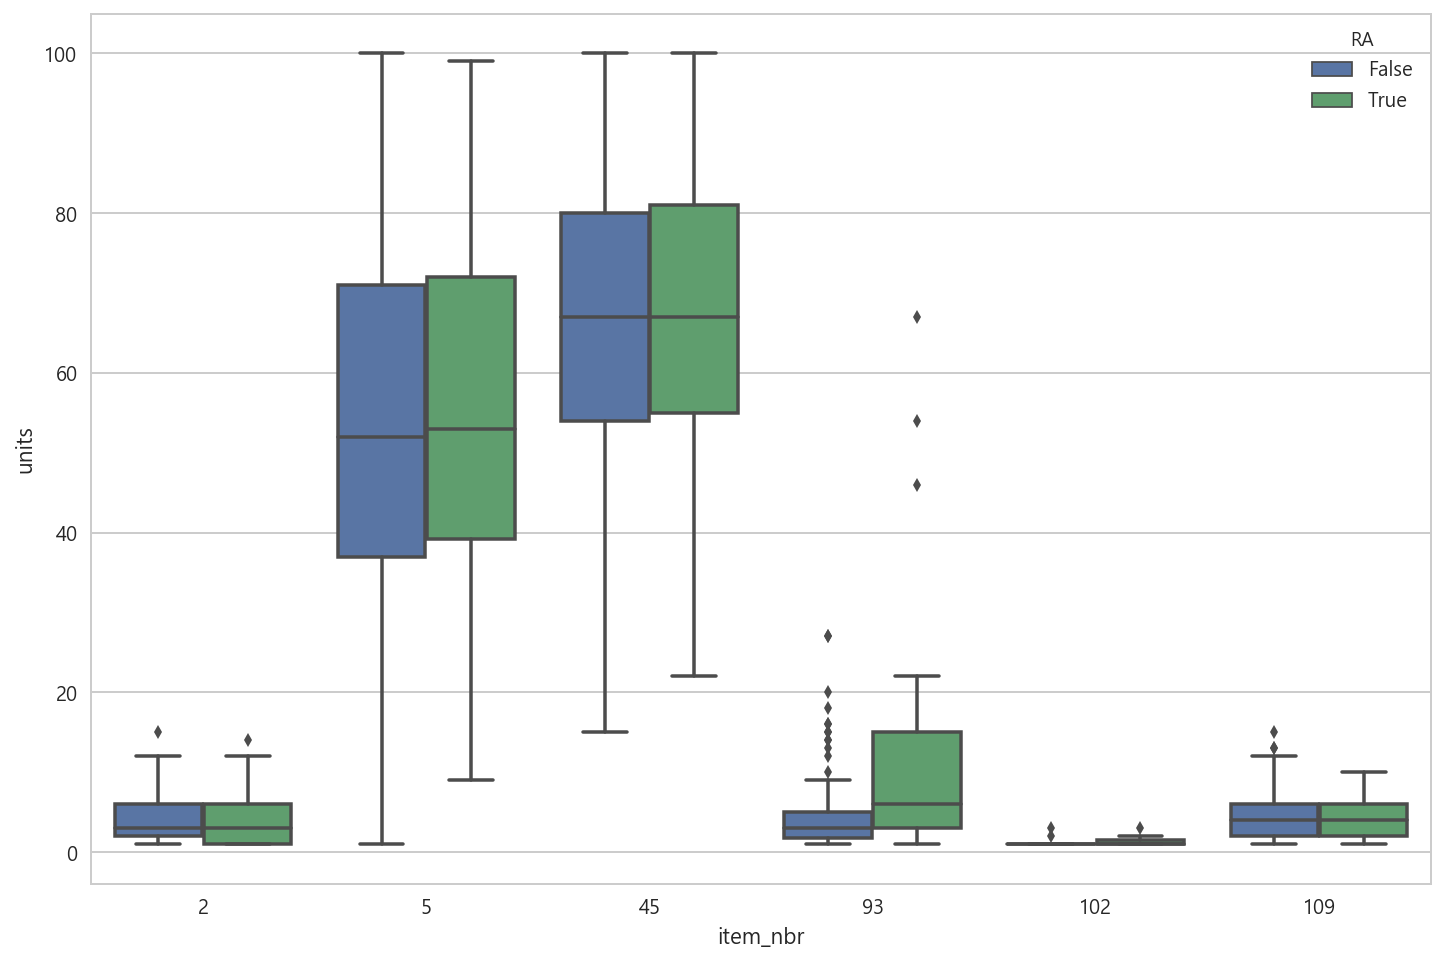

In [115]:
# 2차조건부 스토어, 아이템, 갯수, 요일 (빈도수가 높을수록 진하게 표시됨)
#  └-- hist, plot, bar 등

#조건설정
cond = master[(master["store_nbr"]==3)&(master["units"]<=100)&(master["units"]>0)]
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(x="item_nbr", y="units", hue="RA", data=cond)
# ["RA","BR","HZ","TS","FG","SN"]
plt.show()

---
# 시간분석(date / month / DOW)

### - 각 아이템넘버기준 X요일/Y판매량

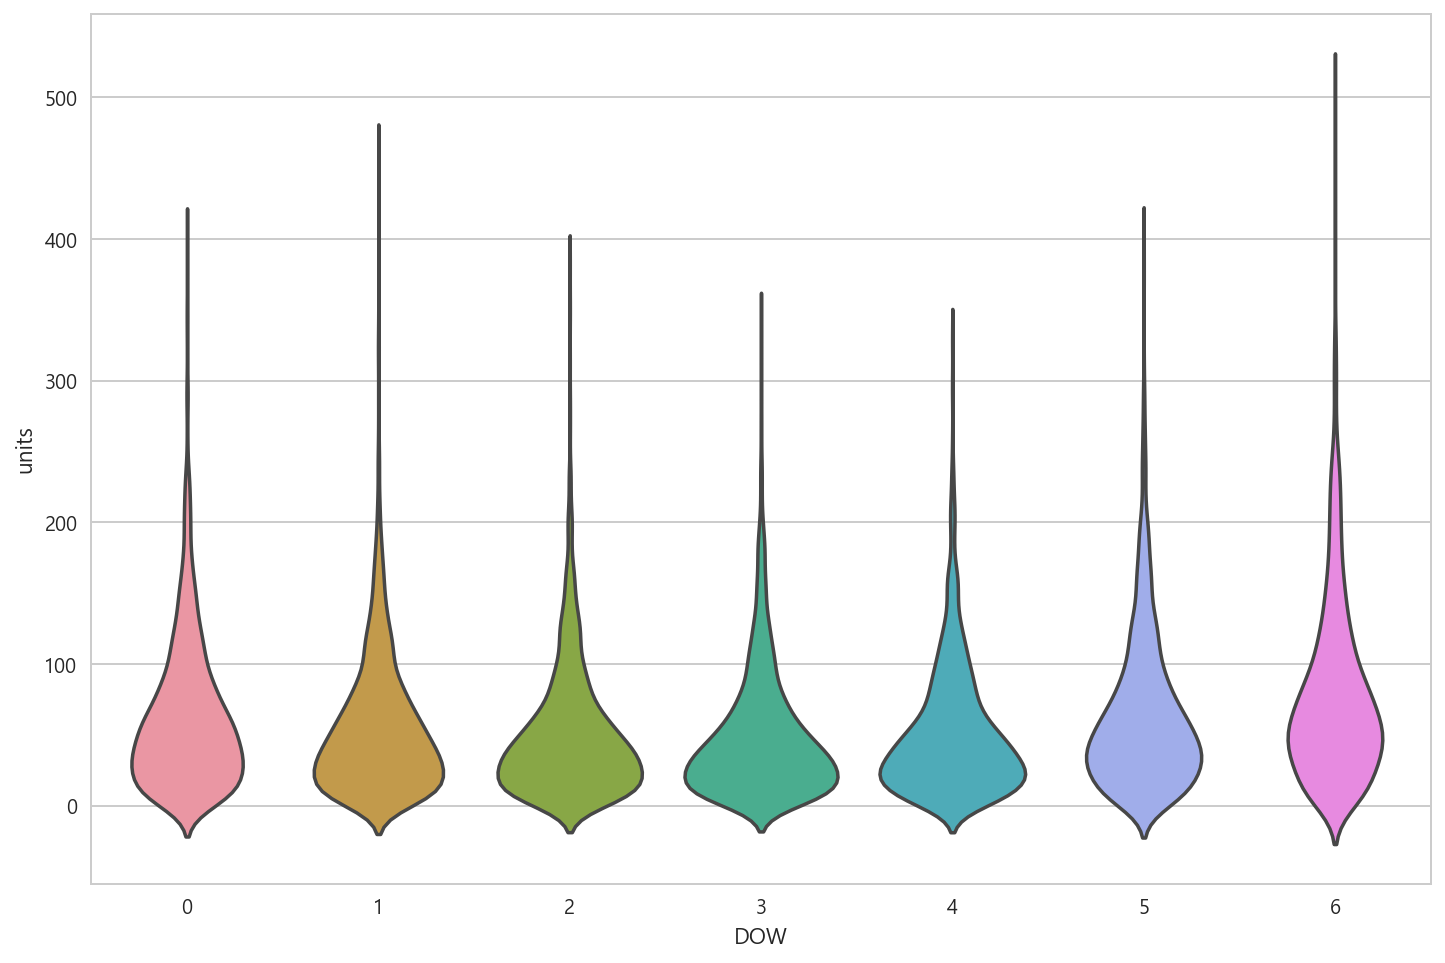

In [61]:
#대표적으로 2번아이템의 경우
item2 = master[master["item_nbr"]==9]
# item2.plot.scatter(x="preciptotal",y="units",figsize=(12,8))

fig, ax = plt.subplots(figsize=(12,8))
sns.violinplot(ax=ax, x="DOW", y="units", data=item2, inner=None)
# sns.swarmplot(ax=ax, x="DOW", y="units", data=item2, color="0.9")
plt.show()

### - 아이템 넘버기준 X시즌/Y판매량

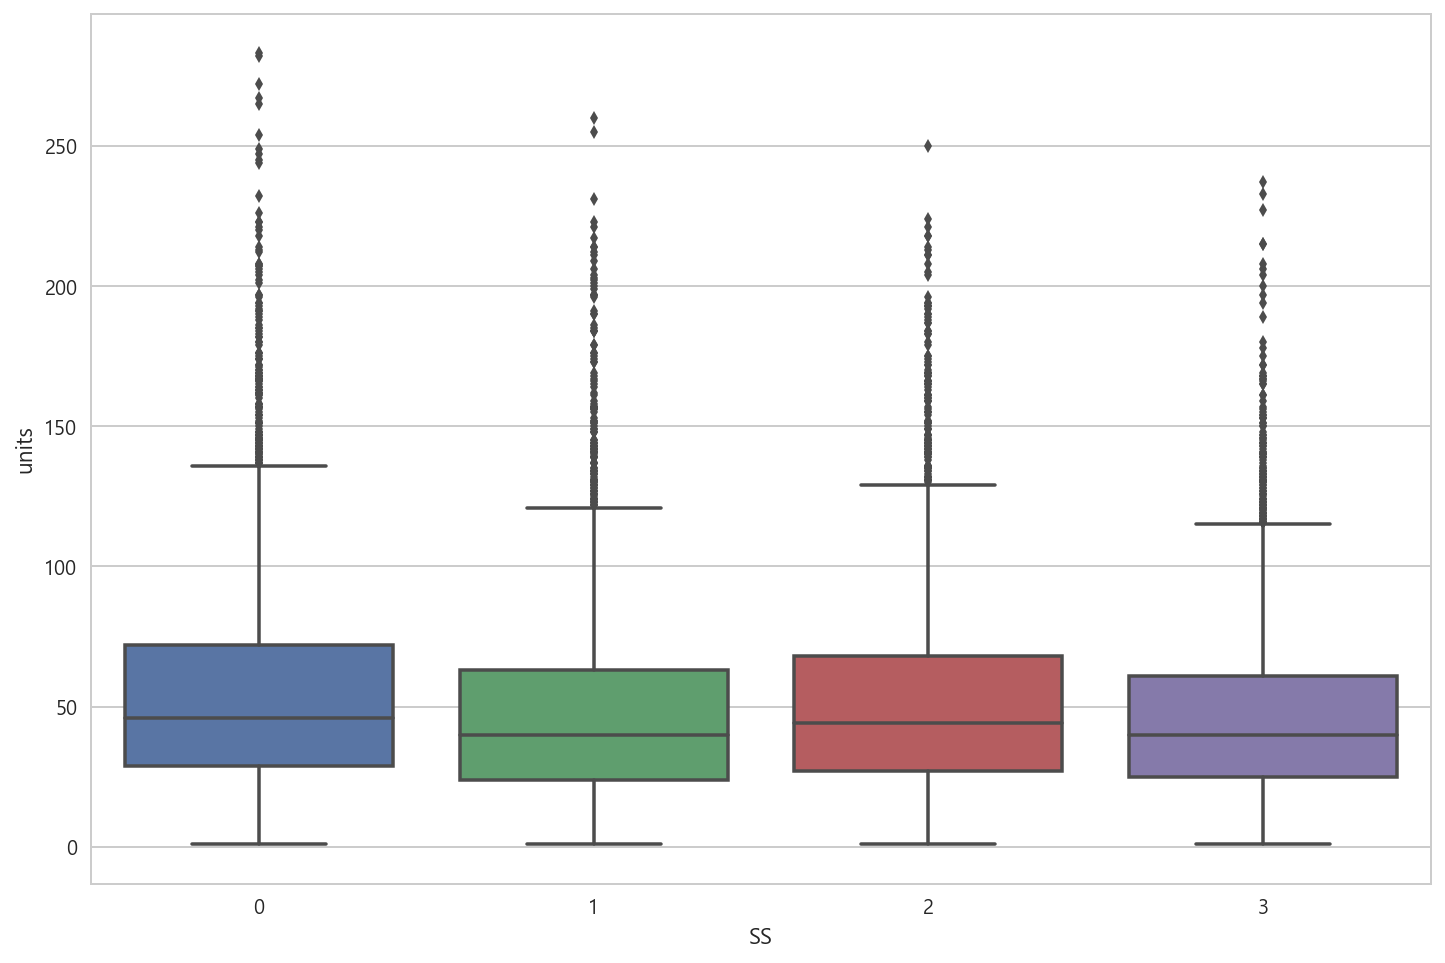

In [117]:
##### 각 아이템별 X시즌/Y판매량
item_n = master[(master["units"]>0)&(master["units"]<300)&(master["item_nbr"]==5)]
# master[master["item_nbr"]==12].plot.scatter(x="month",y="units",figsize=(12,8),style="hex")
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(ax=ax, x="SS", y="units", data=item_n)
plt.show()

### - 각 아이템넘버기준 X월별/Y판매량

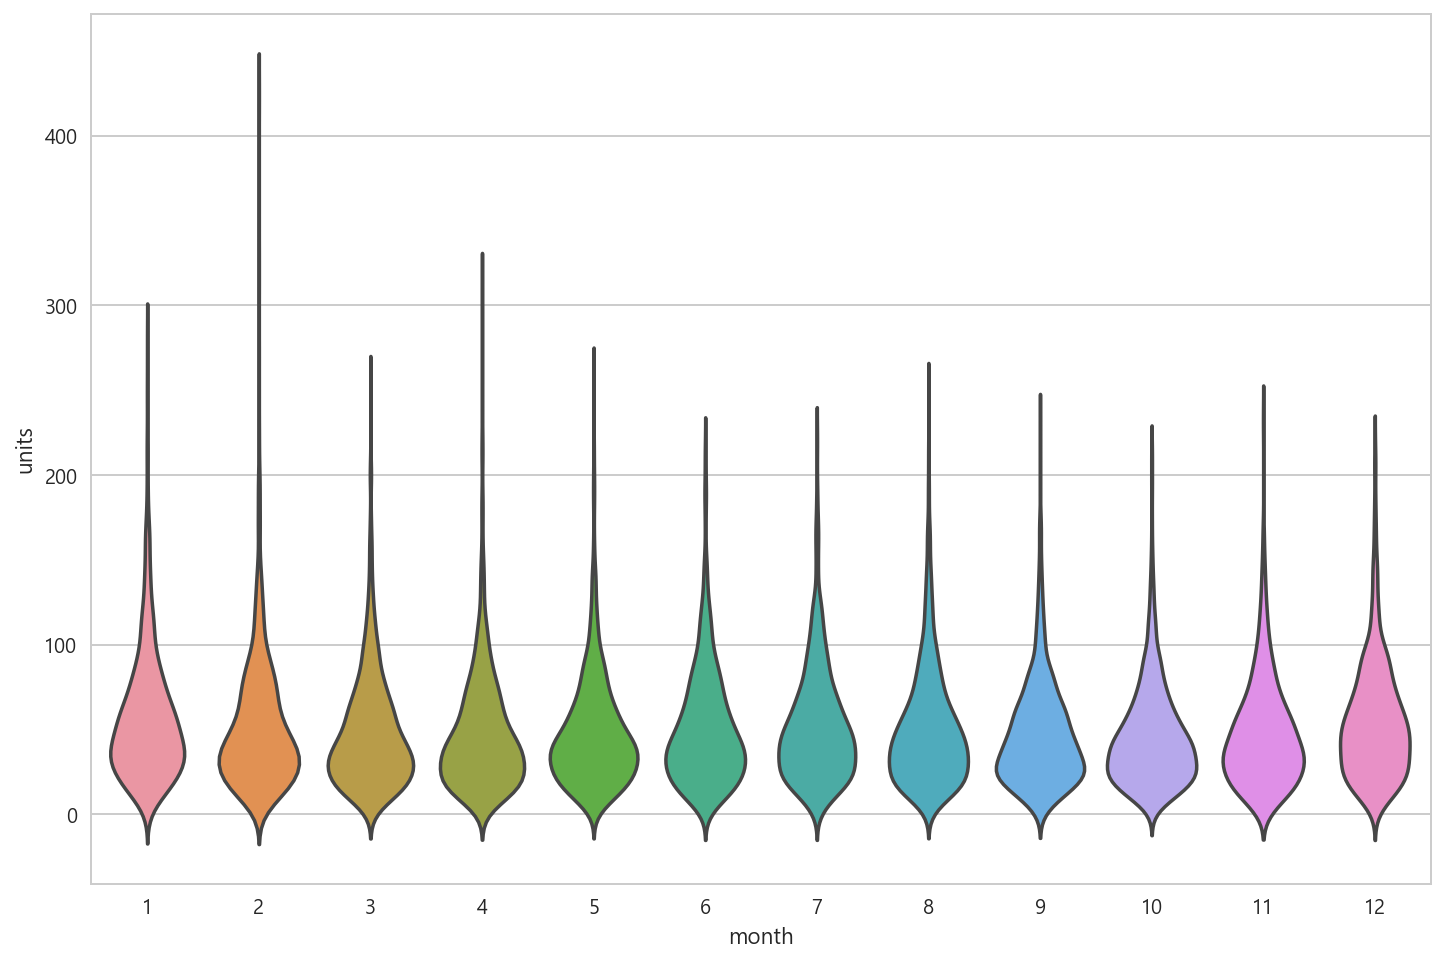

In [122]:
#각 아이템별 X월/Y판매량
item_n = master[(master["item_nbr"]==5)&(master["units"]<2000)]
# master[master["item_nbr"]==12].plot.scatter(x="month",y="units",figsize=(12,8),style="hex")
fig, ax = plt.subplots(figsize=(12,8))
sns.violinplot(ax=ax, x="month", y="units", data=item_n, inner=None)
plt.show()

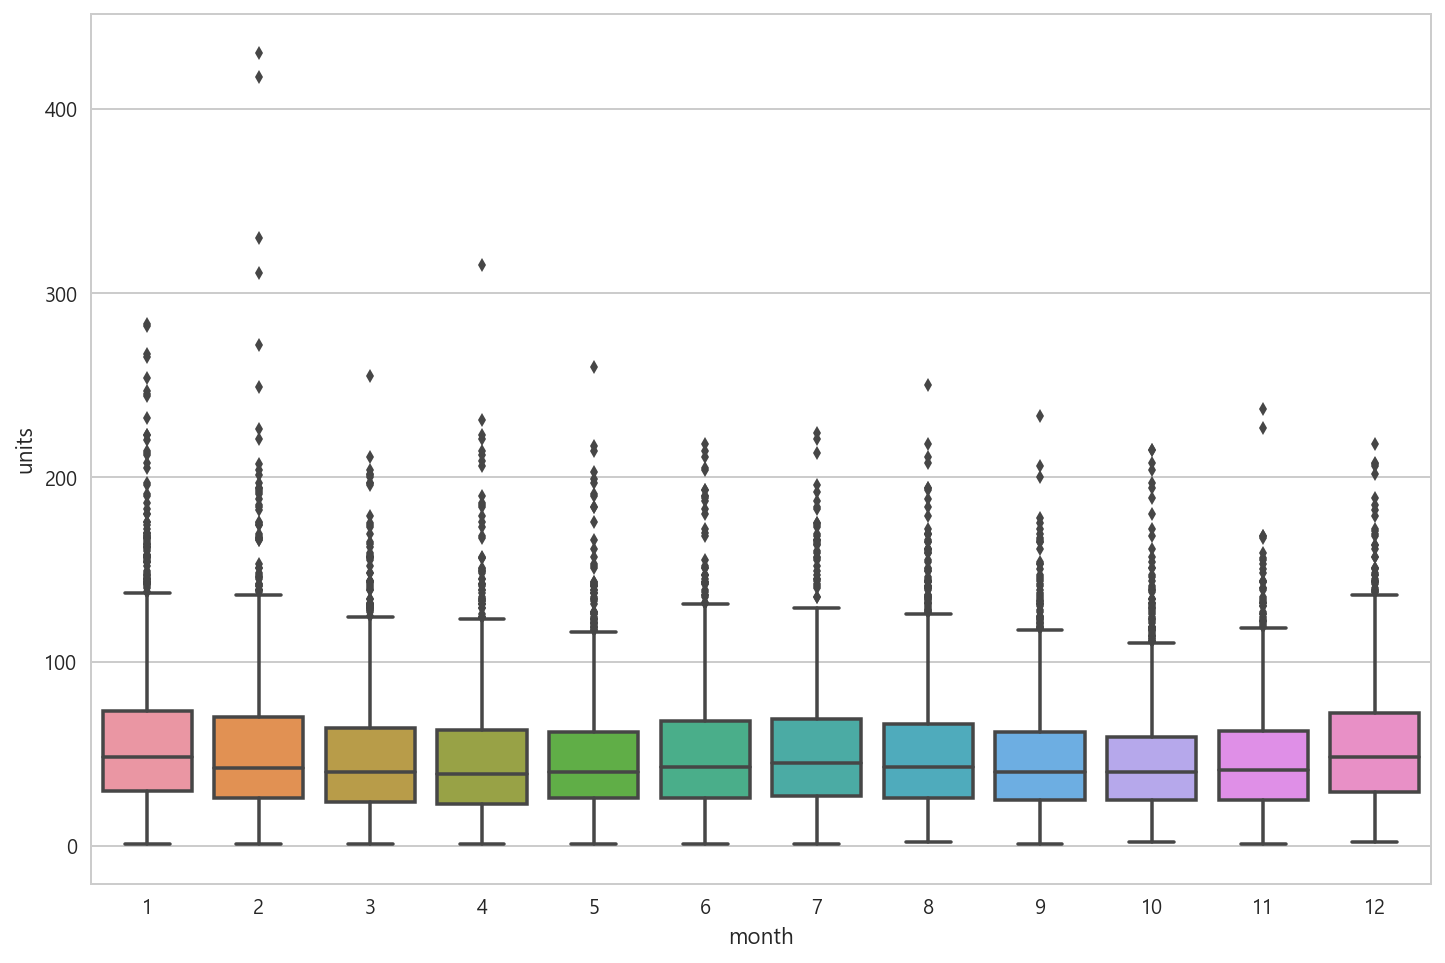

In [123]:
### 각 아이템별 X월/Y판매량
item_n = master[(master["units"]>0)&(master["units"]<2000)&(master["item_nbr"]==5)]
# master[master["item_nbr"]==12].plot.scatter(x="month",y="units",figsize=(12,8),style="hex")
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(ax=ax, x="month", y="units", data=item_n)
plt.show()

### - 각 아이템별 X일/Y판매량

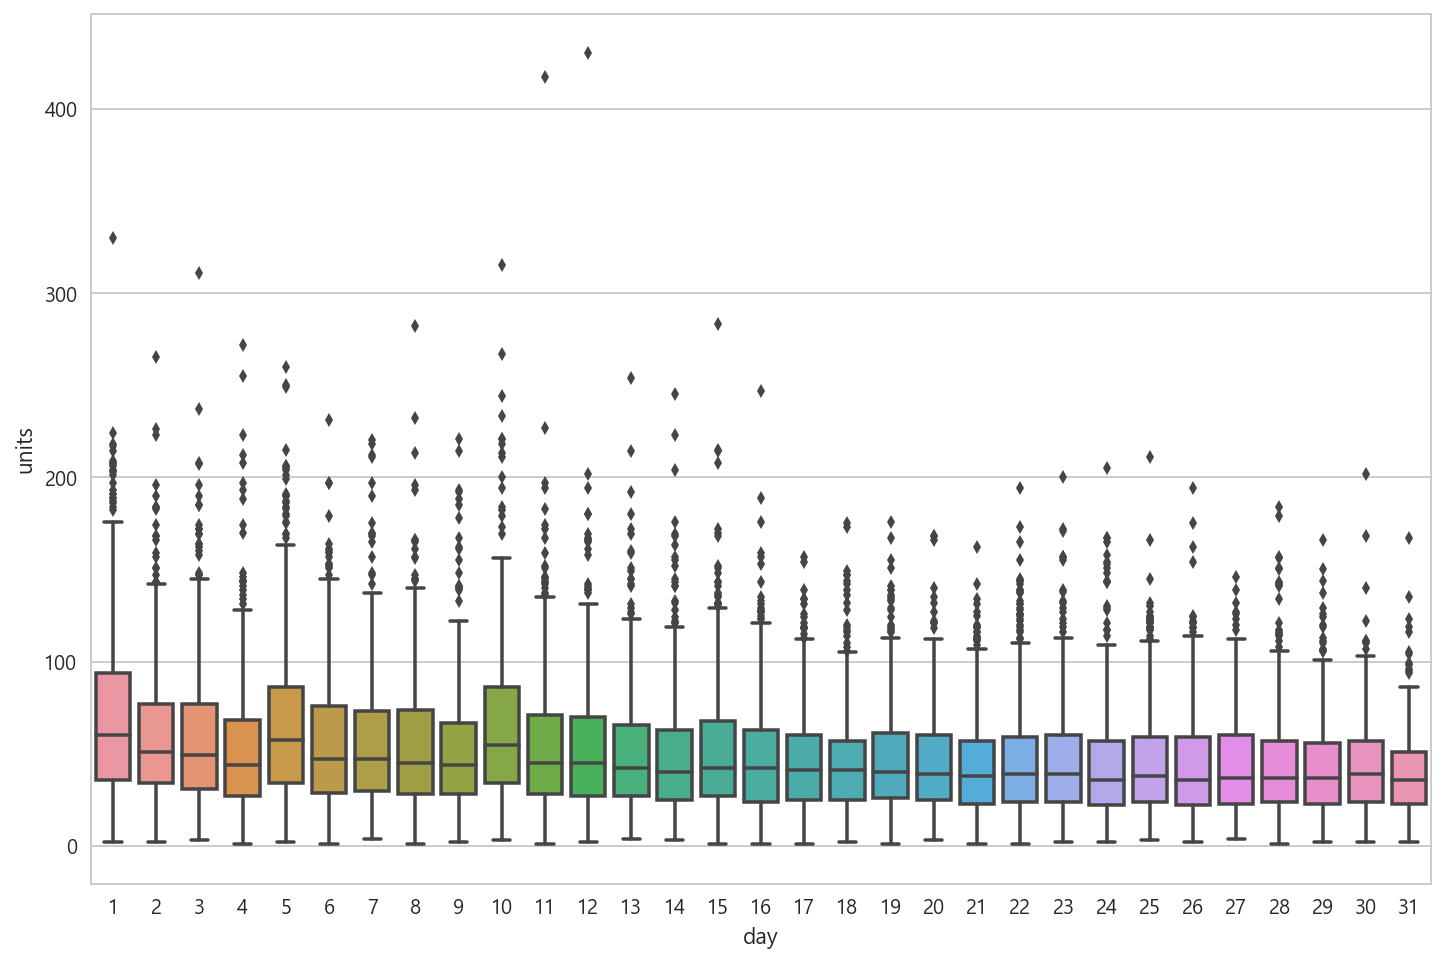

In [60]:
#각 아이템별 X일/Y판매량
item_n = master[(master["units"]>0)&(master["units"]<500)&(master["item_nbr"]==5)]
# master[master["item_nbr"]==12].plot.scatter(x="month",y="units",figsize=(12,8),style="hex")
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(ax=ax, x="day", y="units", data=item_n)
plt.show()

# 날씨별분석

### - 날씨코드정렬

In [145]:
count_code = master.groupby("codesum").size().reset_index(name="counts")
count_code.sort_values("counts", ascending=False).reset_index(drop=True).head(10)

,codesum,counts
0,,65560
1,BR,8079
2,RA,7982
3,RA BR,7522
4,BR HZ,2094
5,SN BR,1865
6,HZ,1859
7,TSRA RA BR,1415
8,TS,1411
9,TSRA,895


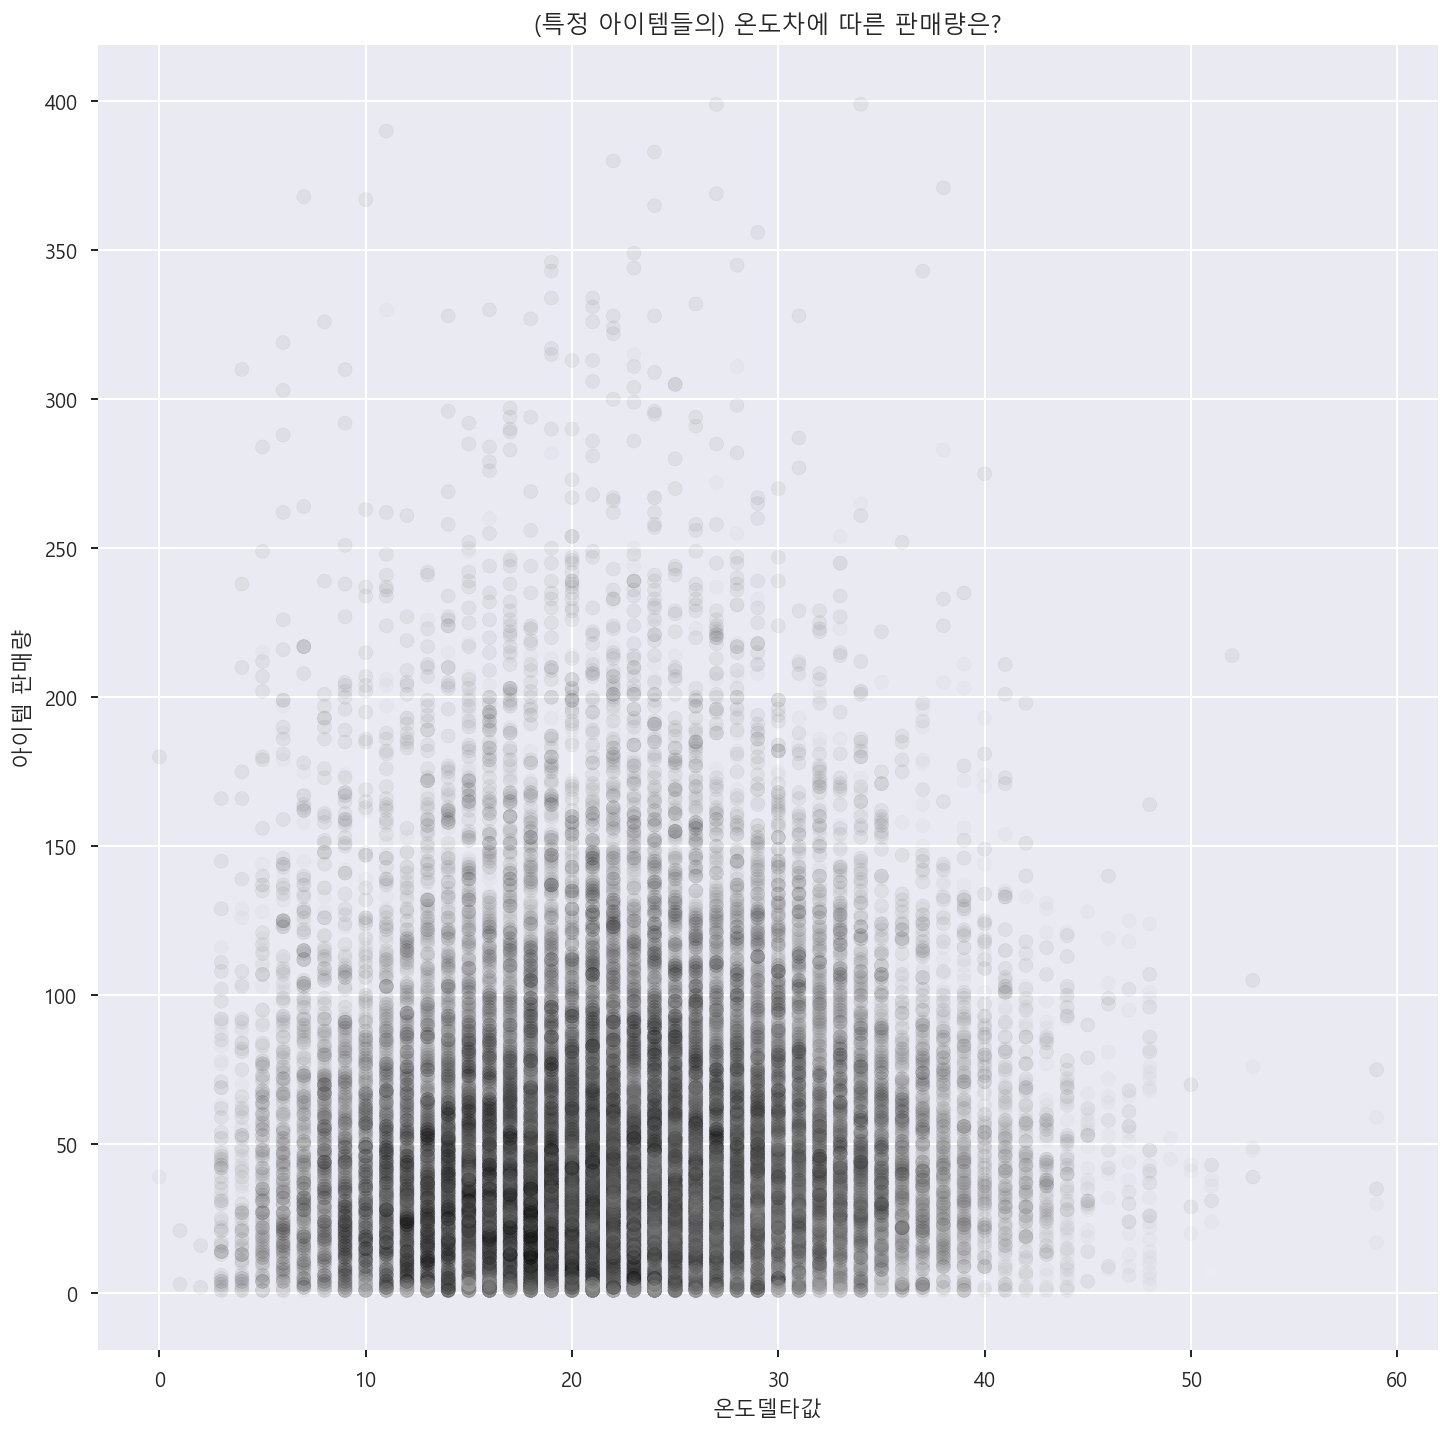

In [156]:
# 1차조건부 스토어, 아이템, 갯수, 요일, 온도차, 비의 여부 (빈도수가 높을수록 진하게 표시됨)
#  └-- scatter 등

#조건설정
cond = master[(master["item_nbr"]<=9)&(master["units"]<400)]

plt.figure(figsize=(12,12))
c = cond["item_nbr"]
x = cond["tdelta"]
# y2 = cond["DOW"]
y1 = cond["units"]
plt.scatter(x, y1, c=c, alpha=0.05)
plt.xlabel("온도델타값")
plt.ylabel("아이템 판매량")
plt.title("(특정 아이템들의) 온도차에 따른 판매량은?")
# plt.xticks(10)
# plt.yticks(10)
# plt.grid()
plt.show()

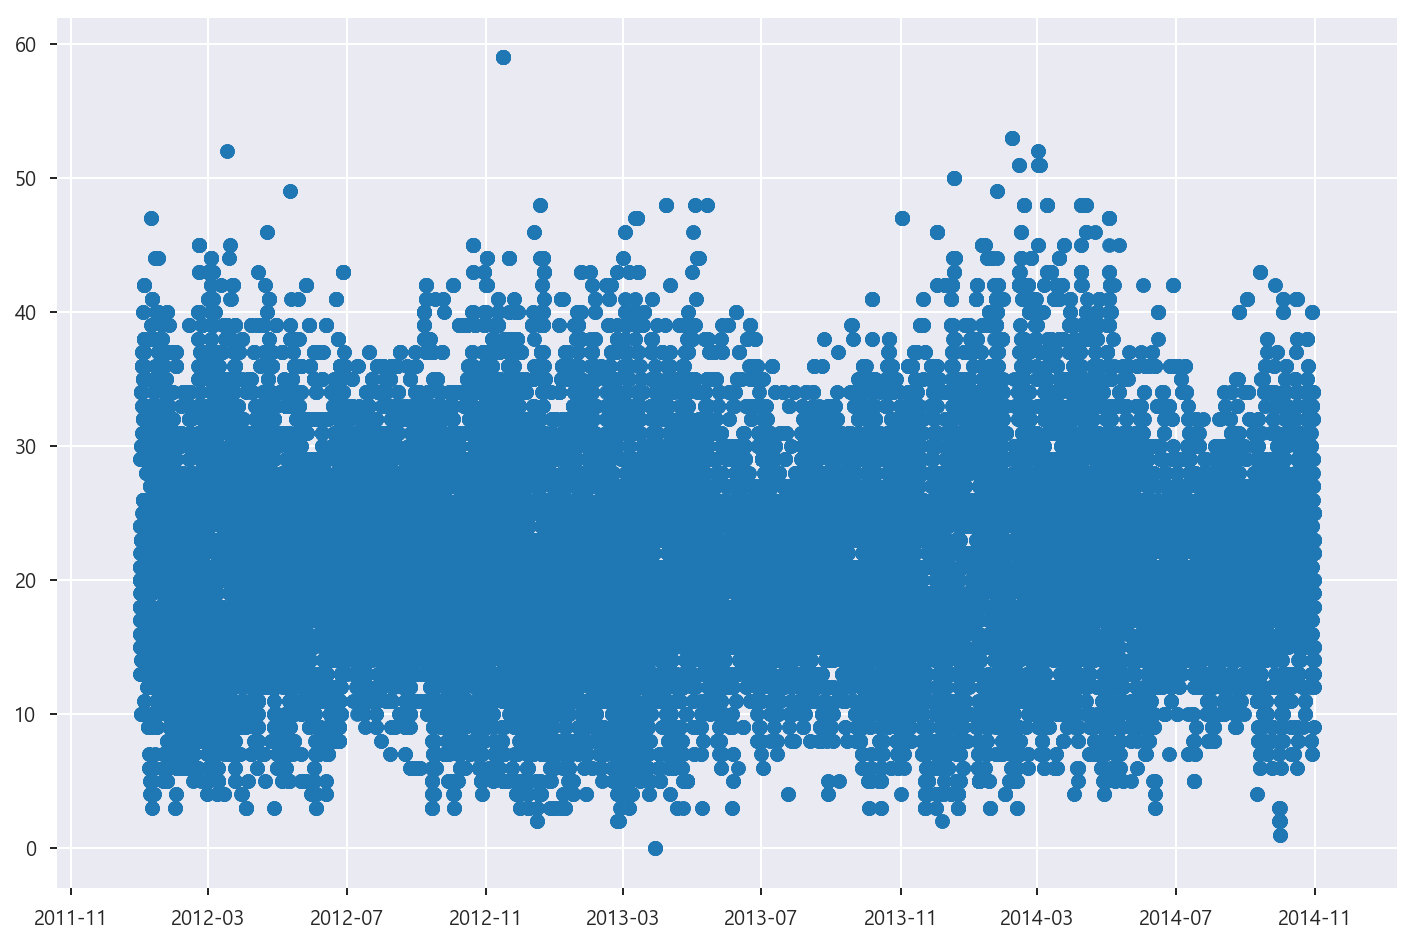

In [158]:
#델타값의 날짜별 스캐터링
plt.figure(figsize=(12,8))
X = [pd.to_datetime(d) for d in master['date']]
plt.scatter(X,master["tdelta"])

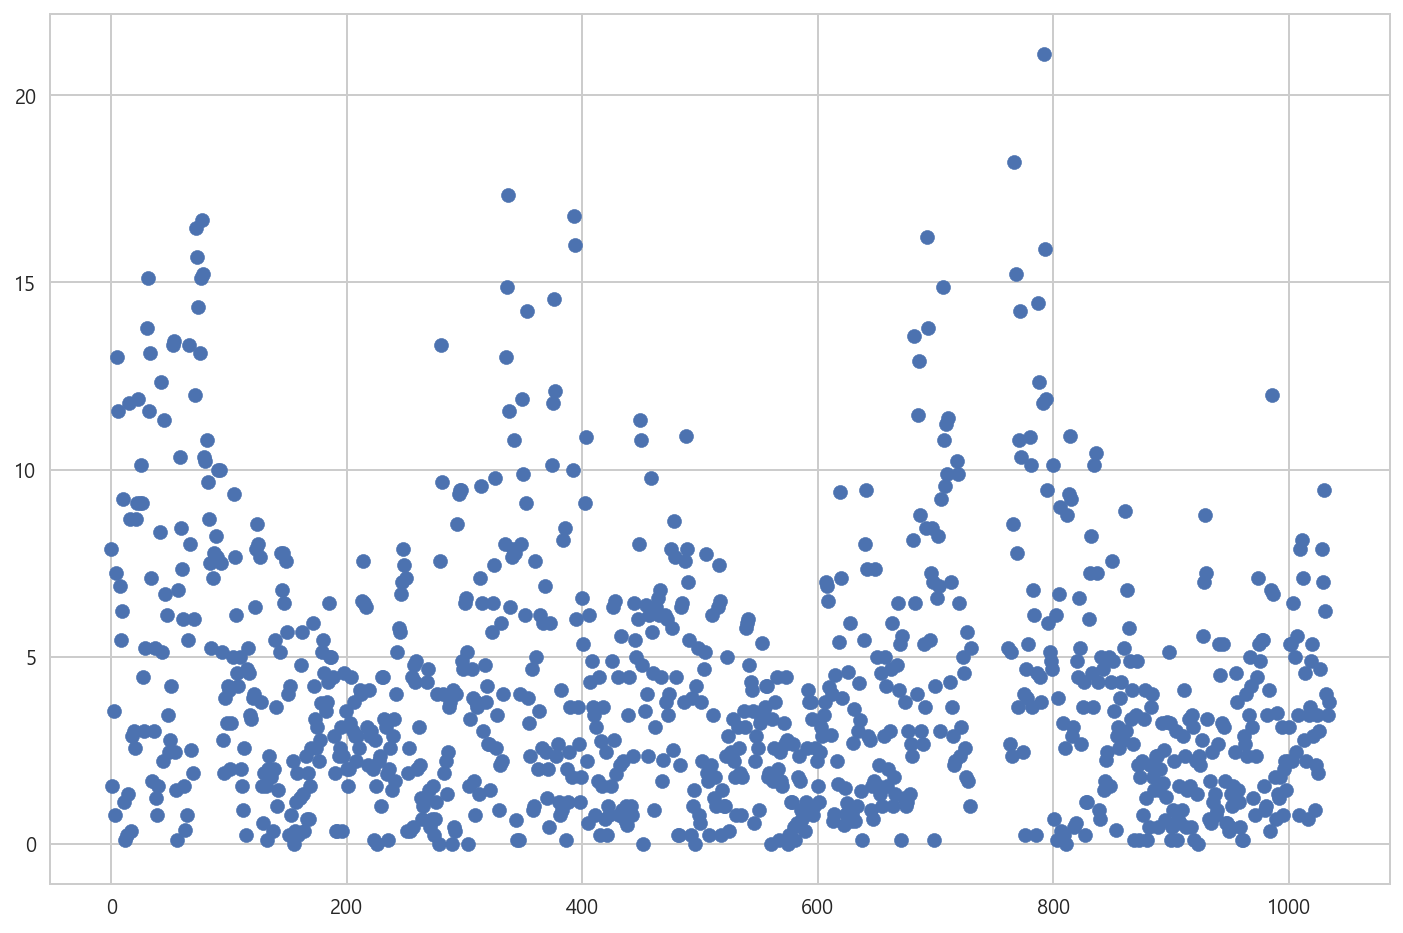

In [38]:
#전체 스테이션 평균 depart의 scatter
plt.figure(figsize=(12,8))
plt.scatter(range(len(station_depart_avg)),abs(station_depart_avg))

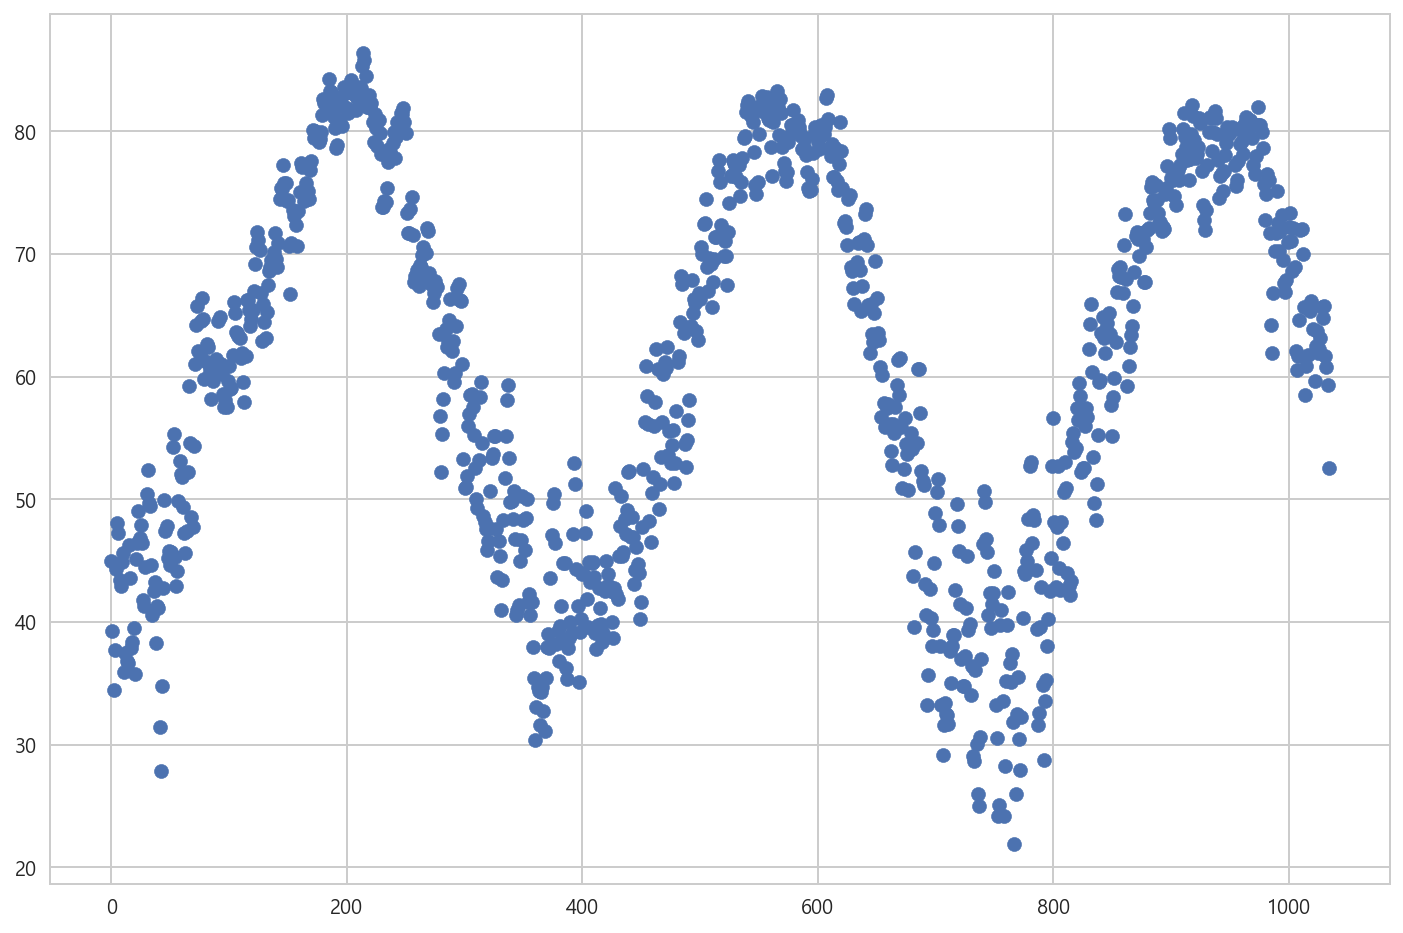

In [40]:
#전체 스테이션 평균 depart의 scatter
plt.figure(figsize=(12,8))
plt.scatter(range(len(station_temp_avg)),abs(station_temp_avg))

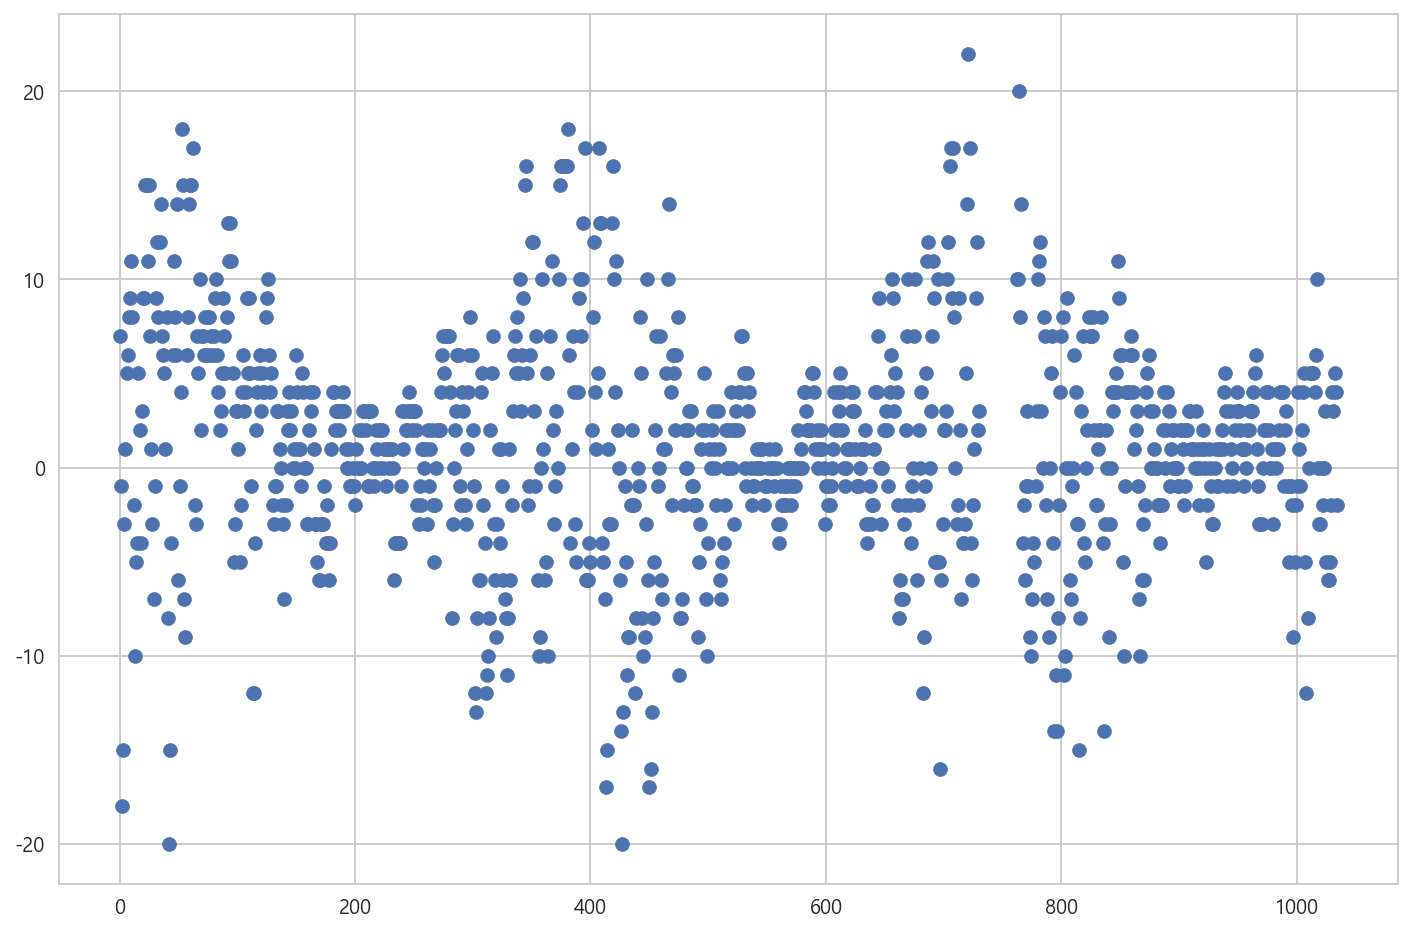

In [342]:
#일부 스테이션 depart의 분포
plt.figure(figsize=(12,8))
plt.scatter(range(len(station_depart)),station_depart[11])

In [ ]:
station_depart

In [ ]:
#독립변수간의 차이 선형회귀...

from sklearn.datasets import load_boston
boston = load_boston()
dfX0 = pd.DataFrame(boston.data, columns=boston.feature_names)
# dfX0.tail()

dfX = sm.add_constant(dfX0)
dfy = pd.DataFrame(boston.target, columns=["MEDV"])

model_boston2 = sm.OLS(dfy, dfX)
result_boston2 = model_boston2.fit()
print(result_boston2.summary())

In [ ]:
fig = sm.graphics.plot_regress_exog(result_master, "units")
plt.show()

# 기타 도움되는자료

In [128]:
#마지막 치팅 correlation 값 보기
item_df = master[(master["item_nbr"]==5)&(master["units"]<400)]
pdp.ProfileReport(item_df)

Number of variables,36
Number of observations,16652
Total Missing (%),6.5%
Total size in memory,3.9 MiB
Average record size in memory,246.0 B
Numeric,23
Categorical,1
Boolean,6
Date,1
Text (Unique),0
Rejected,5
